In [1]:
import sys
sys.path.append("../../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

from scipy.optimize import curve_fit
from scipy.special import gamma
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

def radius_to_capacitance(np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*3.9
    cap     = factor*np_radius

    return cap

def exp_saturation(t, tau, a0):
    return a0*(1 - np.exp(-t/tau))
def stretched_exp_saturation(t, tau, a0, beta):
    return a0*(1 - np.exp(-(t/tau)**beta))
def streched_moments(tau, beta, n=1):
    return gamma(n/np.array(beta))*(np.array(tau)**n)/np.array(beta)

### 2 Electrode Setup

In [35]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_input_vs/"
folder                  = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_two_step_input/"
U_0                     = 0.1
Ne                      = 2
N_voltages              = 200000
t_vals                  = np.arange(N_voltages-1)*1e-10*1e9
# steps_between_storage   = [0,100,200,400,600,800,1000,1200,1600,1800,2000,3000,4000,5000,7500,10000,20000,30000,40000,50000]
steps_between_storage   = [0,100,120,140,160,180,200,220,240,260,280,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,
                           2200,2400,2600,2800,3000,3200,3400,3600,3800,4000,4200,4400,4600,4800,5000,5200,5400,5600,5800,
                           6000,6200,6400,6600,7500,10000,20000,30000,40000,50000]
# steps_between_storage   = [300,500,700,900,1100,1300,1400,1500,1700,1900]
data                    = {steps : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne={Ne}_{steps}.csv") for steps in steps_between_storage}
pot                     = {steps : pd.read_csv(f"{folder}mean_state_Nx=9_Ny=9_Nz=1_Ne={Ne}_{steps}.csv") for steps in steps_between_storage}

In [36]:
# folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
# U_0         = 0.1
# N_voltages  = 200000
# t_true      = np.arange(N_voltages-1)*1e-10*1e9
# cap         = 5e3
# data_true   = pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=2_{cap}.csv")
# y_true      = data_true['Current'].copy().values*1000

stop    = 30000
t_true  = t_vals.copy()[:stop]
y_true  = data[0]['Current'].values[:stop]*1000

In [37]:
def multi_exp_saturation(t, *params):
    t0              = params[0]
    t_shift         = np.clip(t - t0, 0, None)
    # t_shift         = t - t0
    n_components    = (len(params)-1) // 2
    results         = np.zeros_like(t, dtype=float)
    for i in range(n_components):
        a_i     =   params[1+2*i]
        tau_i   =   params[1+2*i+1]
        results +=  a_i * (1 - np.exp(-t_shift/tau_i))
    return results

N               = 5
p0              = [1 for _ in range(2*N+1)]
p_true, c_true  = curve_fit(multi_exp_saturation, t_true, y_true, p0=p0, maxfev=100000)
t0_true         = p_true[0]

def scaled_exp_saturation(t, lam, t0):
    t_shift         = np.clip(t - t0, 0, None)
    # t_shift         = t - t0
    n_components    = (len(p_true)-1) // 2
    results         = np.zeros_like(t, dtype=float)
    for i in range(n_components):
        a_i     =   p_true[1+2*i]
        tau_i   =   p_true[1+2*i+1]
        results +=  a_i * (1 - np.exp(-lam*t_shift/tau_i))

    return results

# def multi_exp_saturation(t, a0, tau0, beta, t0):
#     t_shift = np.clip(t - t0, 0, None)
#     return a0*(1-np.exp(-(t_shift/tau0)**beta))

# p_true, c_true  = curve_fit(multi_exp_saturation, t_true, y_true, bounds=(0,np.inf), maxfev=10000)

# def scaled_exp_saturation(t, lam, t0):
#     t_shift = np.clip(t - t0, 0, None)
#     return p_true[0]*(1-np.exp(-lam*(t_shift/p_true[1])**p_true[2]))

p_true

array([1.75681412e+01, 2.38863441e+01, 4.65157020e+02, 2.17449999e+00,
       9.55248980e+01, 4.79306004e+01, 3.43149575e+03, 3.31666755e-04,
       2.85375569e+03, 3.03971462e+01, 4.65155443e+02])

Text(0.5, 0, '$t$ [ns]')

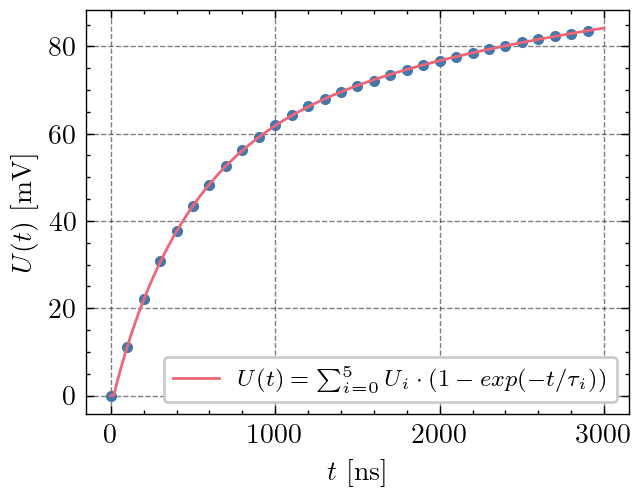

In [38]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_true, y_true, '.', markevery=1000)
ax.plot(t_true, multi_exp_saturation(t_true, *p_true), label='$U(t)=\\sum_{i=0}^5 U_i\cdot(1-exp(-t/\\tau_i))$')
ax.legend(fontsize='small')
ax.set_ylabel("$U(t)$ [mV]")
ax.set_xlabel("$t$ [ns]")

In [39]:
steps_per_step  = 15000
step_idx        = [[0,steps_per_step,steps_per_step+steps,2*steps_per_step+steps] for steps in steps_between_storage]
start           = 0

t   = t_vals[start:step_idx[0][3]]
y   = data[0].iloc[step_idx[0][0]+start:step_idx[0][3]]['Current'].values*1000
p,c = curve_fit(scaled_exp_saturation, t, y, maxfev=10000, bounds=(0, np.inf))

t1  = t_vals[start:step_idx[0][1]]
y1  = data[0].iloc[step_idx[0][0]+start:step_idx[0][1]]['Current'].values*1000
t2  = t_vals[step_idx[0][2]:step_idx[0][3]]
y2  = data[0].iloc[step_idx[0][2]:step_idx[0][3]]['Current'].values*1000

# p1,c1   = curve_fit(scaled_exp_saturation, t1, y1, maxfev=10000, bounds=((0,t0_true-1e-6), (np.inf,t0_true+1e-6)), p0=[1,t0_true])
p1,c1   = curve_fit(scaled_exp_saturation, t1, y1, maxfev=10000)
# p2,c2   = curve_fit(scaled_exp_saturation, t2, y2, maxfev=10000, bounds=((0,t0_true-1e-6), (np.inf,t0_true+1e-6)), p0=[1,t0_true])
p2,c2   = curve_fit(scaled_exp_saturation, t2, y2, maxfev=10000)

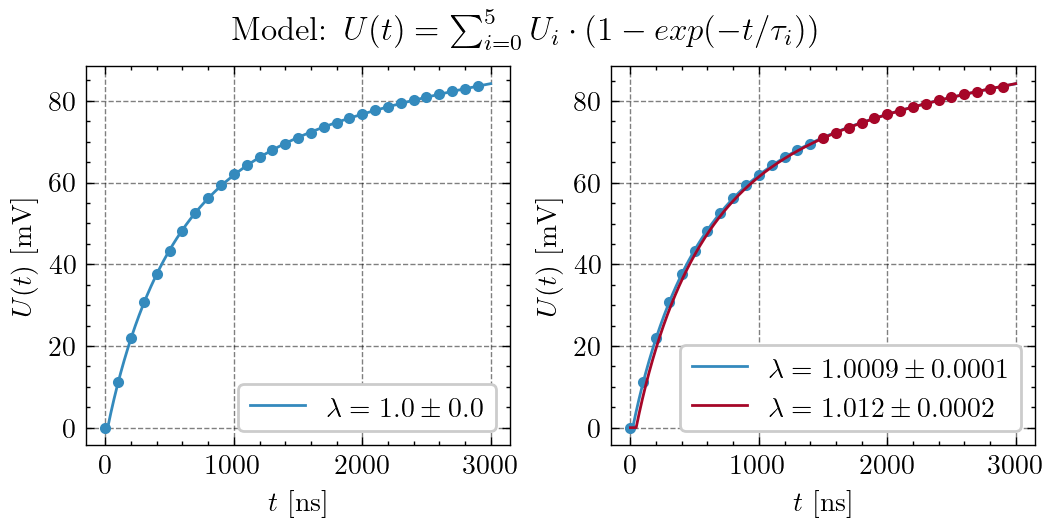

In [40]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot(1,2,1)
ax.plot(t, y, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, scaled_exp_saturation(t,*p), color=nanonets_utils.blue_color,
        label=f"$\\lambda = {np.round(p[0],4)} \pm {np.round(np.sqrt(c[0,0]),4)}$")
ax.legend()
ax.set_ylabel("$U(t)$ [mV]")
ax.set_xlabel("$t$ [ns]")

ax  = fig.add_subplot(1,2,2)
ax.plot(t1, y1, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, scaled_exp_saturation(t,*p1), color=nanonets_utils.blue_color,
        label=f"$\\lambda = {np.round(p1[0],4)} \pm {np.round(np.sqrt(c1[0,0]),4)}$")
ax.plot(t2, y2, '.', markevery=1000, color=nanonets_utils.red_color)
ax.plot(t, scaled_exp_saturation(t,*p2), color=nanonets_utils.red_color,
        label=f"$\\lambda = {np.round(p2[0],4)} \pm {np.round(np.sqrt(c2[0,0]),4)}$")
ax.set_ylabel("$U(t)$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax.legend()

fig.suptitle("Model: $U(t)=\\sum_{i=0}^5 U_i\cdot(1-exp(-t/\\tau_i))$")
fig.savefig("fit.png")

In [41]:
params1 = []
params2 = []
tau1    = []
tau2    = []
t1_vals = []
t2_vals = []
y1_vals = []
y2_vals = []
start   = 0

for i, (key, df) in enumerate(data.items()):
    y   = df['Current'].values*1000

    # First range
    t1  =   t_vals.copy()[step_idx[i][0]+start:step_idx[i][1]]
    y1  =   y.copy()[step_idx[i][0]+start:step_idx[i][1]]
    # p1,_=   curve_fit(scaled_exp_saturation, t1, y1, bounds=((0,t0_true-1e-6),(np.inf,t0_true+1e-6)))
    p1,_=   curve_fit(scaled_exp_saturation, t1, y1, maxfev=10000)
    tau1.append(p1[0])
    t1_vals.append(t1)
    y1_vals.append(y1)
    params1.append(p1)

    # Second range
    t2  =   t_vals.copy()[step_idx[i][2]+start:step_idx[i][3]]
    y2  =   y.copy()[step_idx[i][2]+start:step_idx[i][3]]
    # p2,_=   curve_fit(scaled_exp_saturation, t2, y2, bounds=((0,t0_true+steps_between_storage[i]/10-1e-6),(np.inf,t0_true+steps_between_storage[i]/10+1500+1e-6)))
    p2,_=   curve_fit(scaled_exp_saturation, t2, y2, maxfev=10000)
    tau2.append(p2[0])
    t2_vals.append(t2)
    y2_vals.append(y2)
    params2.append(p2)

tau_df                      = pd.DataFrame([tau1,tau2],index=["$\\tau_1$","$\\tau_2$"], columns=np.array(steps_between_storage)/10).T
tau_df["$\Delta \\tau$"]    = np.abs(tau_df["$\\tau_2$"] - tau_df["$\\tau_1$"])
tau_df

,$\tau_1$,$\tau_2$,$\Delta \tau$
0.0,1.000888,1.012021,0.011133
10.0,1.003560,0.999799,0.003760
12.0,1.001870,0.996731,0.005139
14.0,1.005119,0.989158,0.015960
16.0,0.997718,0.985603,0.012116
18.0,1.007429,0.988862,0.018567
20.0,1.005695,0.975713,0.029982
22.0,1.006440,0.982663,0.023777
24.0,1.007282,0.990694,0.016587
26.0,1.007233,1.020259,0.013026


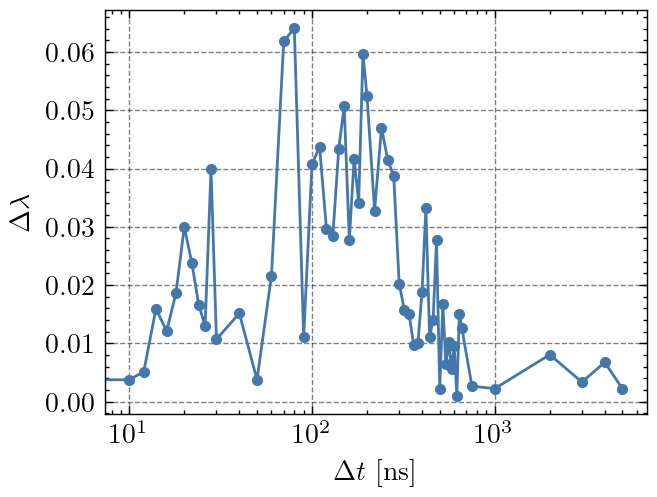

In [42]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(tau_df.index,tau_df.iloc[:,2], '.-')
ax.set_xscale('log')
# ax.set_xlim(0,1000)
# ax.set_ylim(0,0.01)
ax.set_xlabel("$\Delta t$ [ns]")
ax.set_ylabel("$\Delta \\lambda$")
fig.savefig(f"../plots/dc_input/2_electrodes/delta_lam_vs_delta_t.svg", transparent=True)

Text(0.5, 0, '$t$ [ns]')

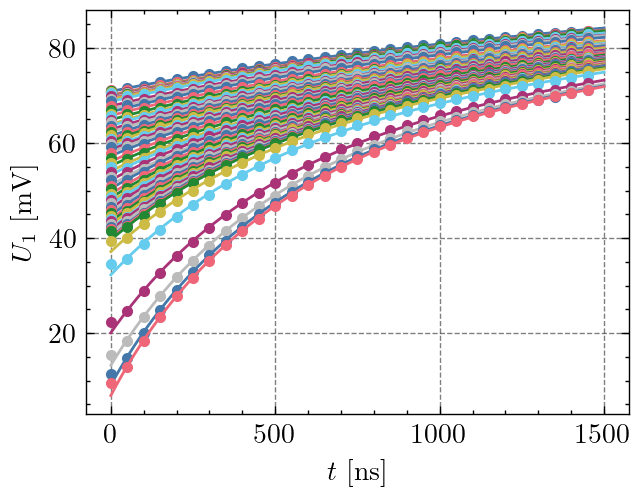

In [43]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for idx in range(len(t2_vals)):
    p = ax.plot(t1_vals[idx], y2_vals[idx], '.', markevery=500)
    ax.plot(t1_vals[idx], scaled_exp_saturation(t2_vals[idx],*params2[idx]), color=p[0].get_color())

    # p = ax.plot(t2_vals[idx], y2_vals[idx], '.', markevery=500)
    # ax.plot(t2_vals[idx], scaled_exp_saturation(t2_vals[idx],*params2[idx]), color=p[0].get_color())
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlabel("$t$ [ns]")
# ax.set_ylim(0,85)
# ax.set_xscale('log')
# fig.savefig(f"../plots/dc_input/2_electrodes/fit_2.svg", transparent=True)

Text(0, 0.5, '$t_0-t_{step}$ [ns]')

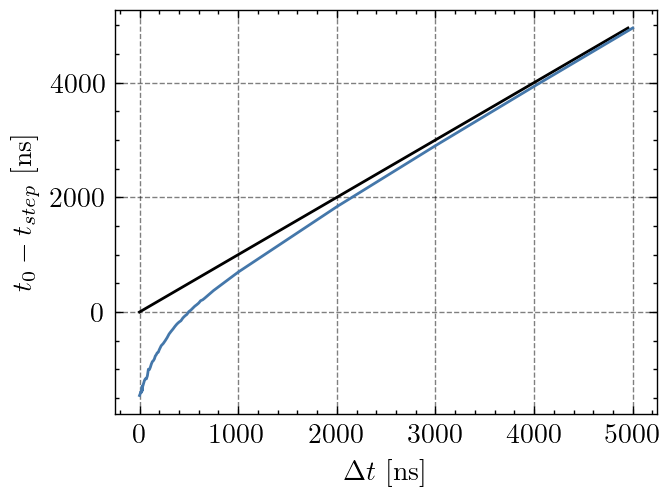

In [44]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(tau_df.index,np.array(params2)[:,1]-1500)
ax.plot(np.arange(0,np.max(np.array(params2)[:,1])-1500), np.arange(0,np.max(np.array(params2)[:,1])-1500), c='black', zorder=1)
# ax.set_xscale('log')
ax.set_xlabel("$\Delta t$ [ns]")
ax.set_ylabel("$t_0-t_{step}$ [ns]")

---

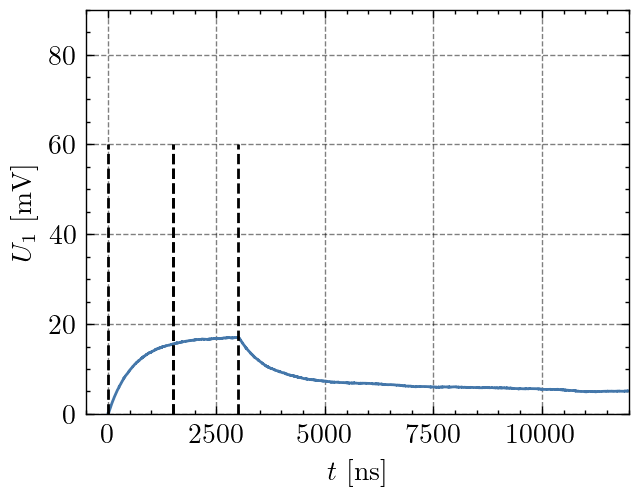

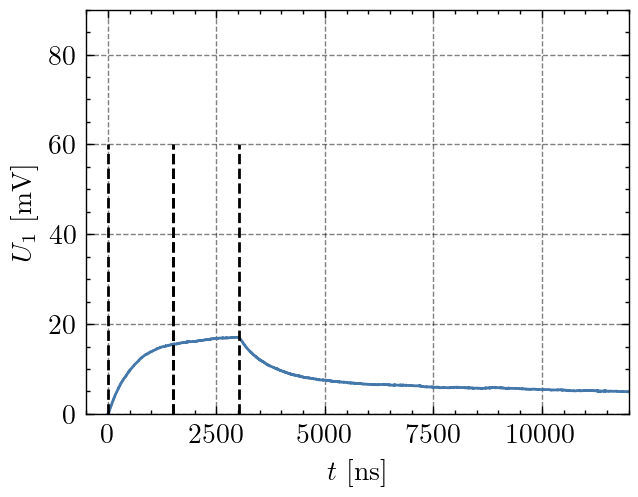

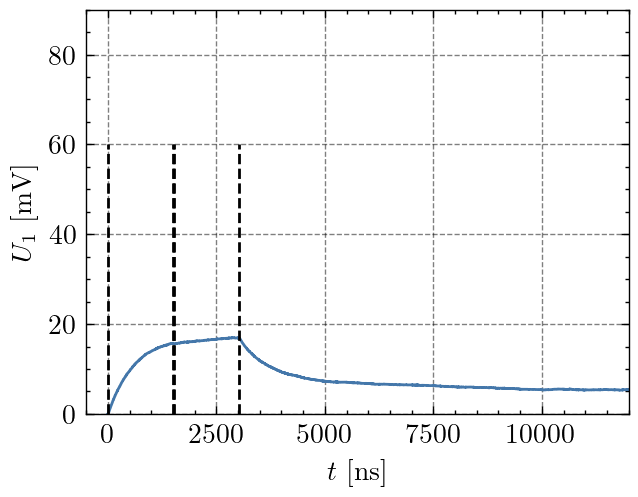

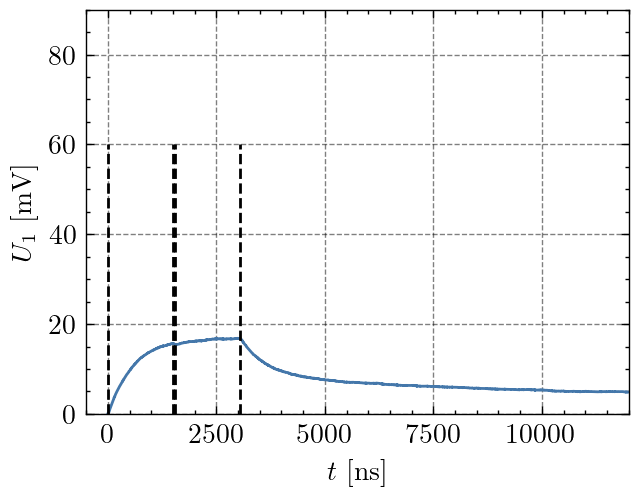

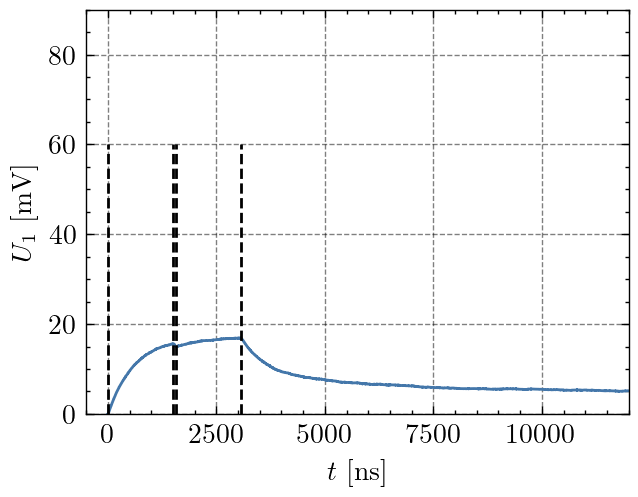

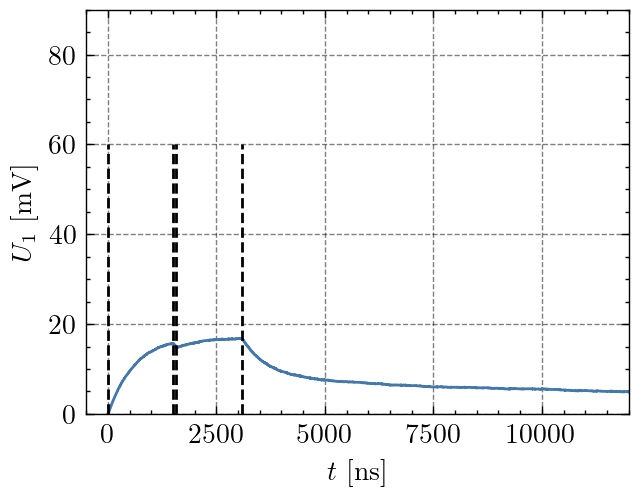

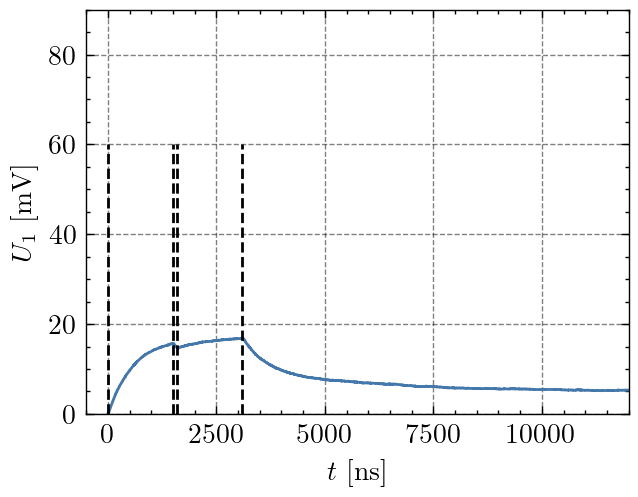

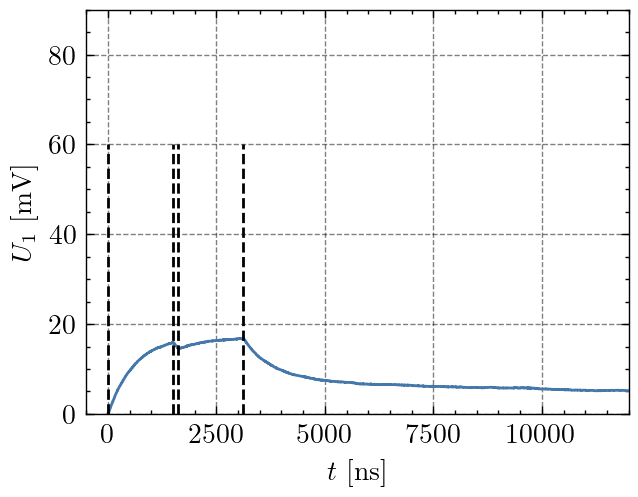

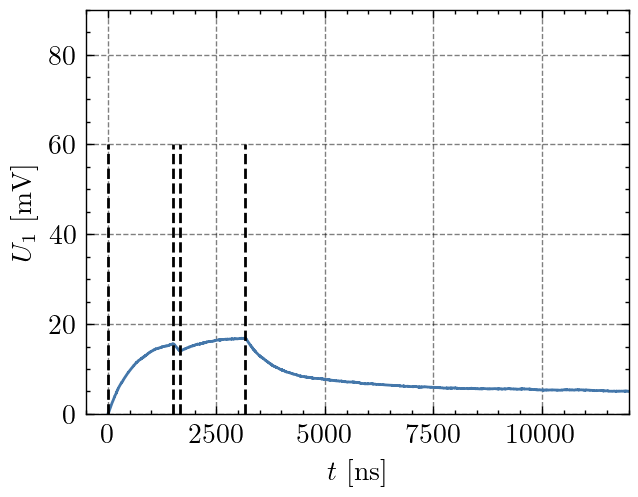

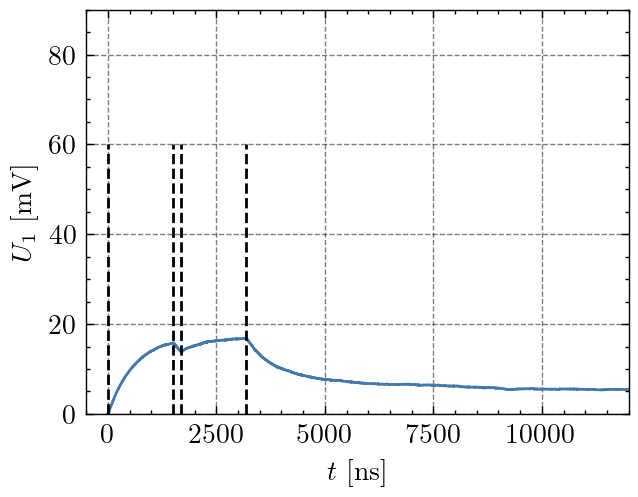

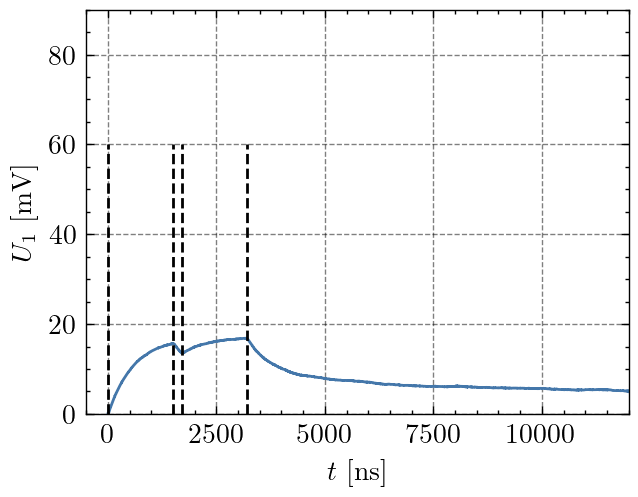

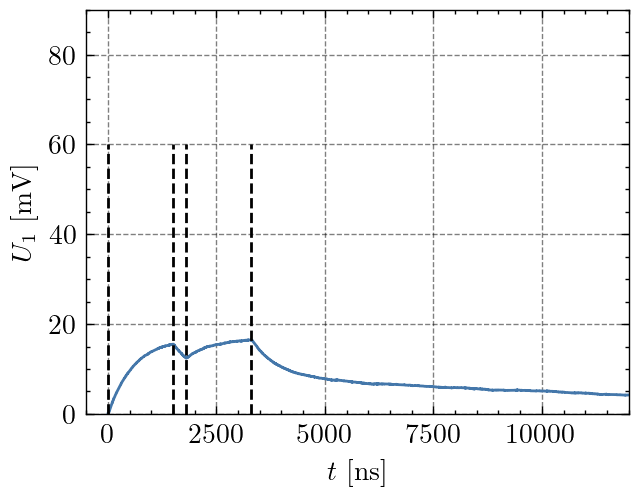

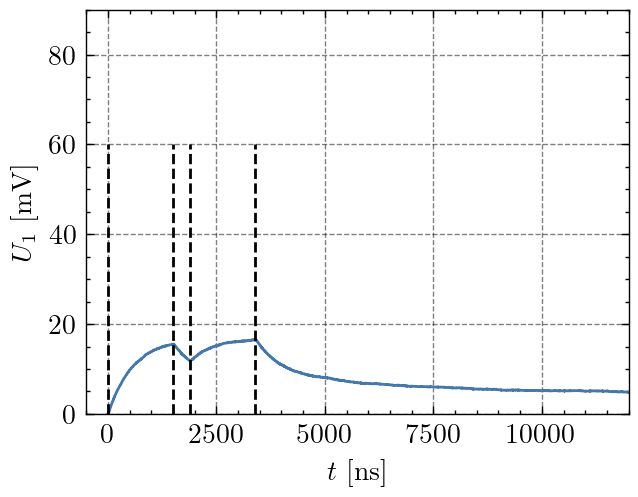

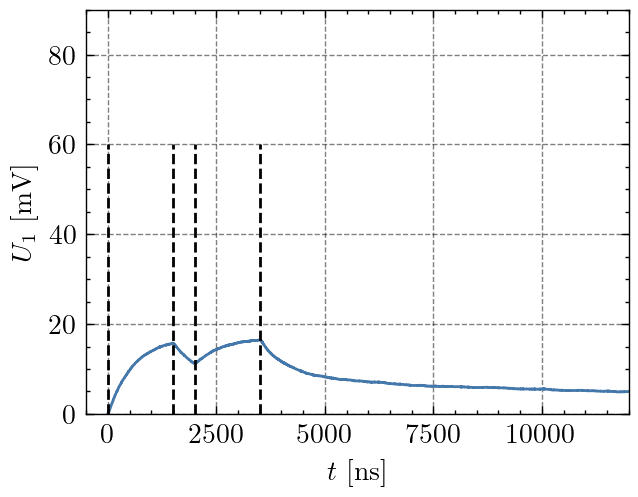

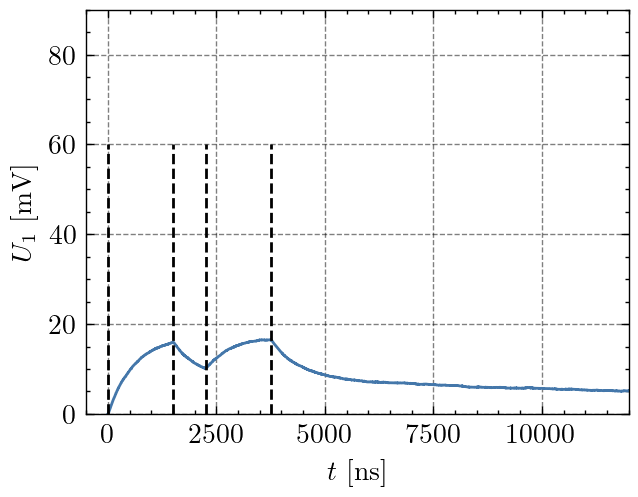

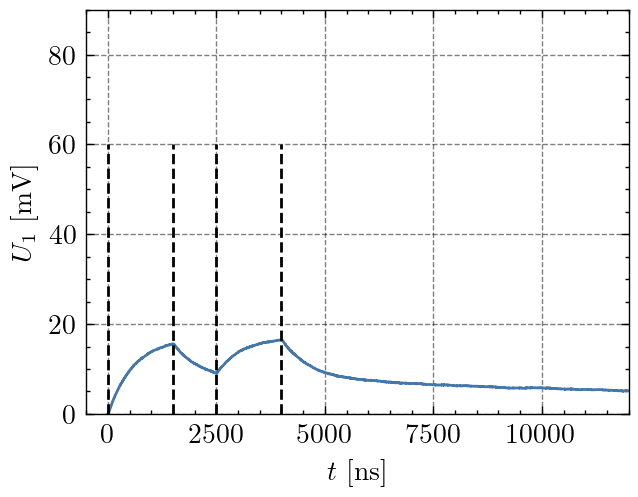

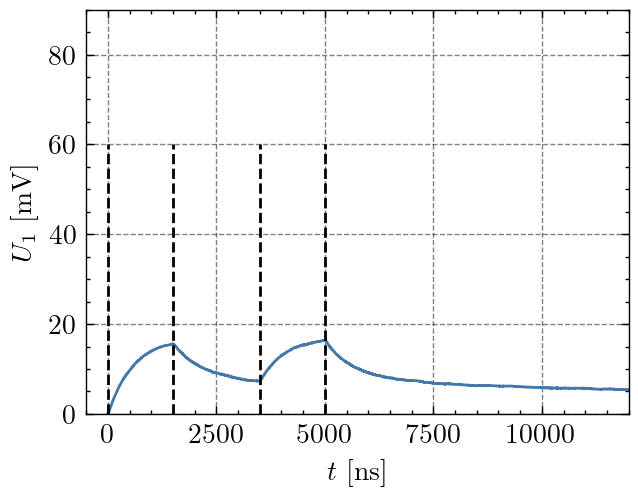

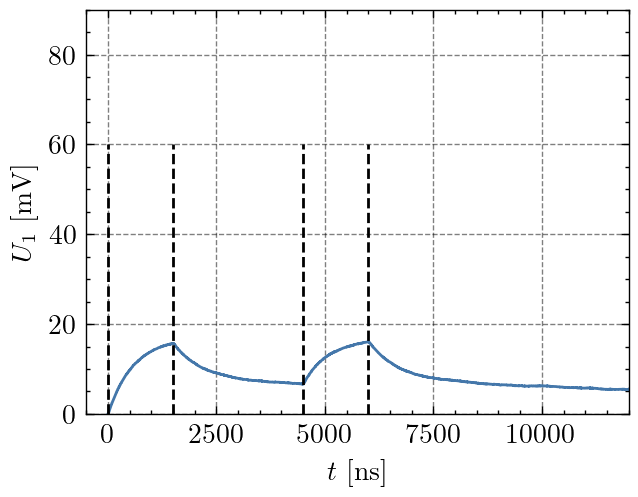

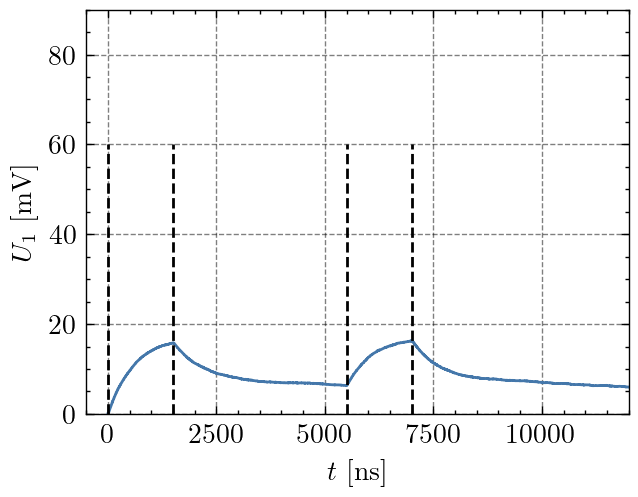

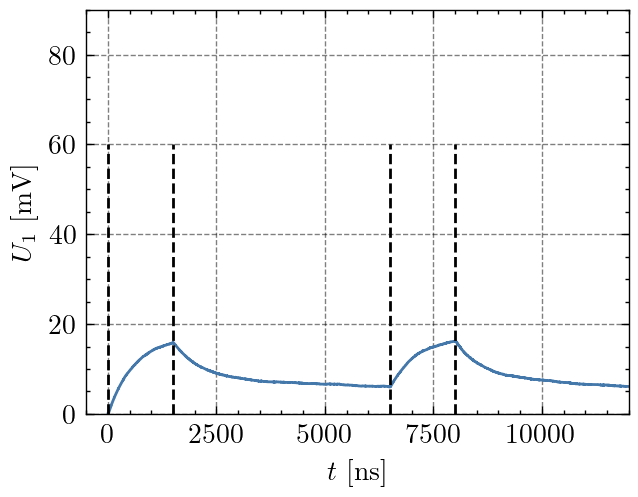

In [465]:
for steps in steps_between_storage:

    y_min   = 0
    y_max   = 100
    idx     = np.where(steps==np.array(steps_between_storage))[0][0]
    fig     = plt.figure(dpi=200)
    ax      = fig.add_subplot()
    y       = data[steps]['Current'].values*1000
    y_e     = data[steps]['Error'].values*1000

    ax.plot(t_vals, y)
    ax.vlines(t_vals[step_idx[idx]], ymin=y_min, ymax=y_max-40, color='black', ls='--')
    ax.set_ylim(y_min, y_max-10)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$U_1$ [mV]")
    ax.set_xlim(-500,12000)
    
    fig.savefig(f"../plots/dc_input/2_electrodes/two_steps/response_{steps}.svg", transparent=True)

---

### Increasing Steps

In [130]:
steps_per_step  = 40000
cap             = 5e3
folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/increasing_steps/"
df              = pd.read_csv(f"{folder}Nx=10_Ny=1_Nz=1_Ne=2_{cap}.csv") 
N_voltages      = len(df)
time_step       = 1e-10
t_vals          = np.arange(N_voltages)*1e-10*1e6

[22.65823247 58.07212674]
[ 3.27628609 17.8294665 ]
[ 7.41421575 43.06513887]
[ 2.98640029 23.38515884]
[ 6.25804016 45.95597669]
[4.97020421 1.42034047]
[ 26.6192968  -37.45821997]
[  4.15274332 -29.64337648]
[  2.49407201 -17.62077896]
[  4.37642488 -37.39508781]


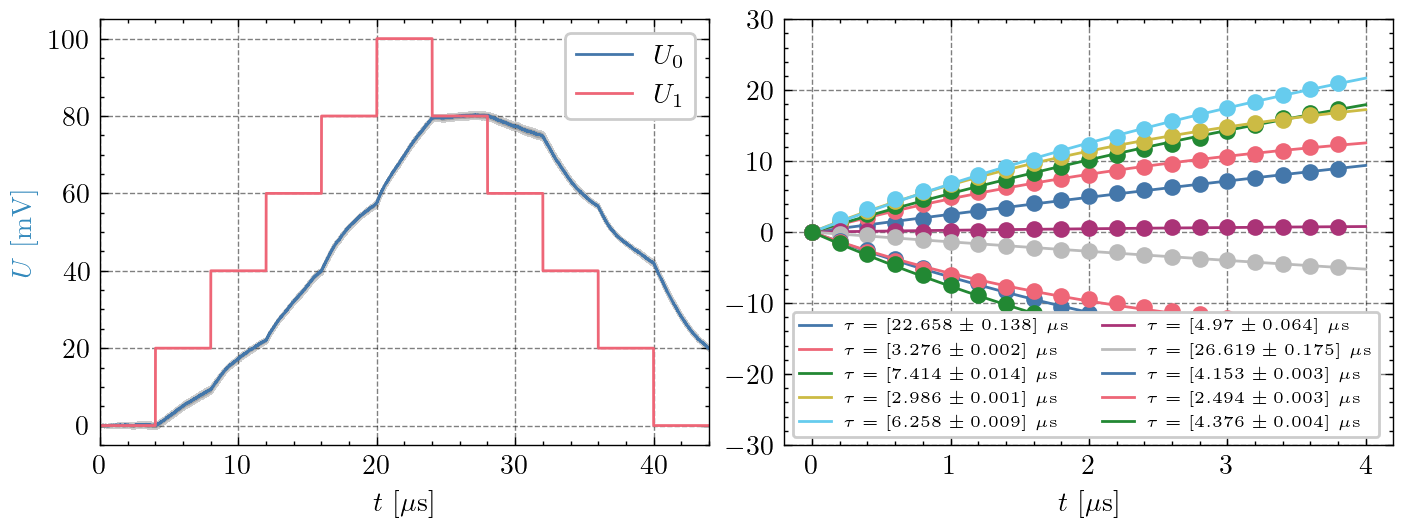

In [131]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000
y   = df['Current'].values*1000
y_e = df['Error'].values*1000

ax.plot(t_vals, y, label='$U_0$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.plot(t_vals, x, label='$U_1$')
ax.set_ylabel('$U$ [mV]', color=nanonets_utils.blue_color)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
for i in range(1,11):
    y1  =   y[i*steps_per_step:(i+1)*steps_per_step].copy()
    y1  -=  y1[0]
    p,c = curve_fit(exp_saturation, t_vals[:len(y1)], y1)
    print(p)
    p1  = ax.plot(t_vals[:len(y1)], y1, 'o', markevery=2000, ms=5)
    ax.plot(t_vals[:len(y1)], exp_saturation(t_vals[:len(y1)], *p), color=p1[0].get_color(),
            label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend(fontsize='xx-small', ncol=2)
ax.set_ylim(-30,30)

fig.savefig(f"../plots/increasing_steps.svg", transparent=True)
fig.savefig(f"../plots/increasing_steps.pdf", transparent=False)

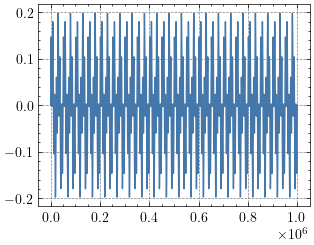

In [106]:
N_voltages  = 1000000
time_step   = 1e-9
U_0         = 0.1
time_steps  = np.arange(N_voltages)*time_step
f0          = 40e3
f1          = 140e3
U_i         = U_0*np.sin(2*np.pi*f0*time_steps) + U_0*np.sin(2*np.pi*f1*time_steps)
plt.plot(U_i)

In [68]:
y1              = y[:steps_per_step]
y2              = y[steps_per_step+steps_between:2*steps_per_step+steps_between]

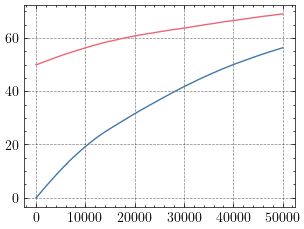

In [69]:
plt.plot(y1)
plt.plot(y2)

In [27]:
t_at_68 = []
U_th    = U_0*0.1 #U_0*0.63

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > U_th)[0][0]])

t_at_68

IndexError: index 0 is out of bounds for axis 0 with size 0

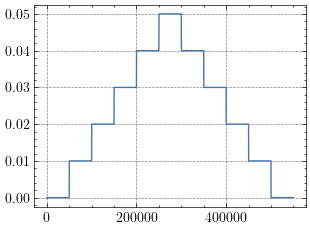

In [66]:
steps_per_step  = 50000
U_step          = 0.01
U_i1            = U_step*np.repeat(np.arange(6),steps_per_step)
U_i2            = U_step*np.repeat(np.arange(4,-1,-1),steps_per_step)
U_i             = np.hstack((U_i1,U_i2))
plt.plot(U_i)

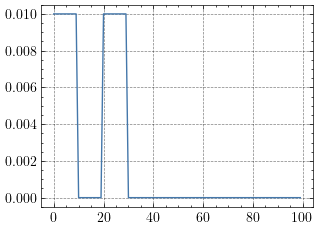

In [24]:
steps_per_step  = 10
steps_between   = 10
start           = 0
U_step          = 0.01
N_voltages      = 100
U_i                                                                             = np.zeros(N_voltages)
U_i[start:steps_per_step]                                                       = U_step
U_i[start+steps_per_step+steps_between:start+2*steps_per_step+steps_between]    = U_step

plt.plot(U_i)

Text(0.5, 0, '$t$ [ns]')

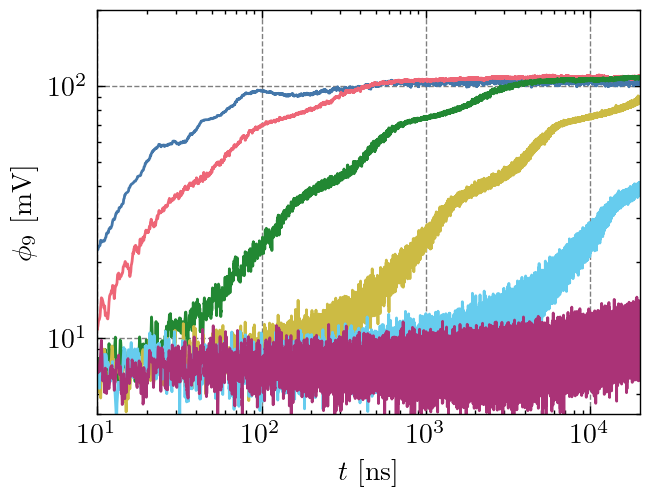

In [162]:
fig = plt.figure(dpi=200)
ax2 = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    p   = pot_cap[key]['9']*1000
    ax2.plot(t_vals, p)

ax2.set_yscale('log')
ax2.set_ylim(5e0,2e2)
ax2.set_xscale('log')
ax2.set_xlim(10,np.max(t_vals))
ax2.set_ylabel('$\phi_9$ [mV]')
ax2.set_xlabel('$t$ [ns]')

In [109]:
t_at_68 = []

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > 0.068)[0][0]])

IndexError: index 0 is out of bounds for axis 0 with size 0

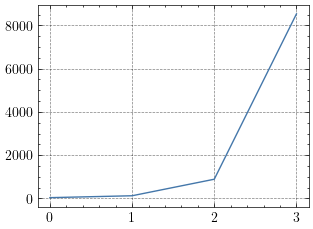

In [111]:
plt.plot(t_at_68)

In [151]:
def exp_saturation(x, tau, a0):
    return a0*(1 - np.exp(-x/tau))
def stretched_exp_saturation(x, tau, beta, a0):
    return a0*(1 - np.exp(-(x/tau)**beta))
def power_law_saturation(x, tau, beta, a0):
    return a0*(1 - (x/tau)**(-beta))
def double_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1 - np.exp(-x/tau1)) + a2*(1 - np.exp(-x/tau2))
def hyperbolic_saturation(x, tau, a0):
    return a0*(1 - 1/(1+x/tau))
def log_saturation(x, tau, a0):
    return a0*(1 - 1/np.log(1+x/tau))
def modified_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1-np.exp(-x/tau1)) + a2*np.exp(-x/tau2)
def logistic_function(x, tau, a0, x0):
    return a0 / (1 + np.exp(-(x-x0)/tau))
def generalized_logistic_function(x, tau, a0, x0, nu1, nu2):
    return a0 / ((1 + nu1*np.exp(-(x-x0)/tau))**(1/nu2))
def exp_power_law_saturation(x, tau1, tau2, alpha, beta, a0):
    return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)

/tmp/ipykernel_29226/3010679329.py:20: RuntimeWarning: invalid value encountered in power
  return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

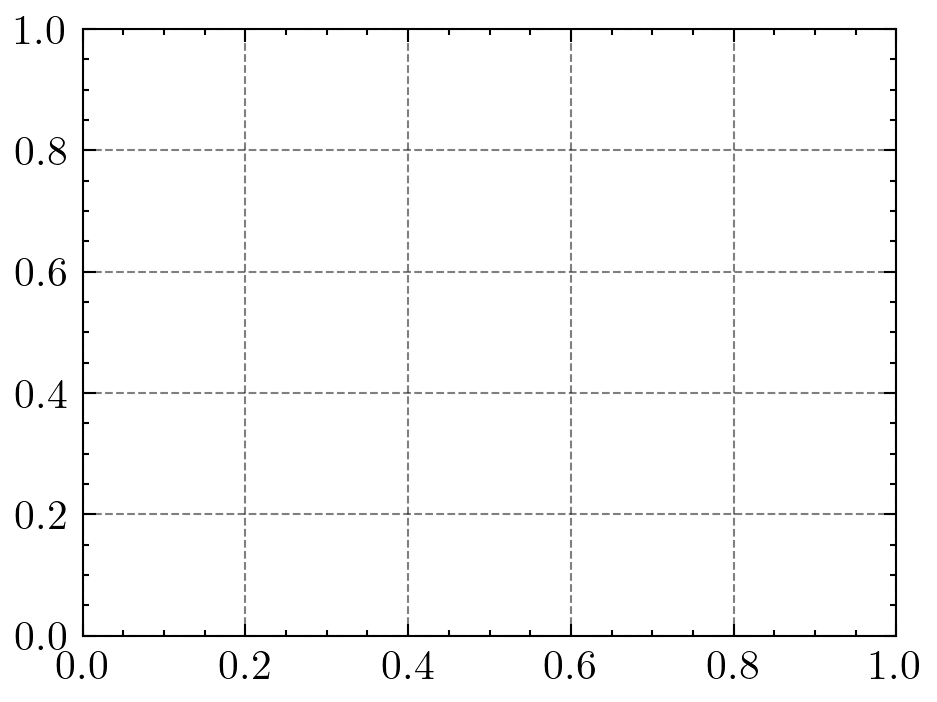

In [153]:
params  = []
stds    = []
func    = exp_power_law_saturation
p0      = [100, 1, 100]

fig = plt.figure(dpi=300)
ax  = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    p,c = curve_fit(func, t_vals, y, maxfev=2000, p0=[key, 10, 1, 1, 1])
    pl  = ax.plot(t_vals, y, '.', ms=1)
    ax.plot(t_vals, func(t_vals, *p), c=pl[0].get_color())

    params.append(p)
    stds.append(np.sqrt(c[0,0]))

    print(p)

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e3)
ax.set_xlim(0,50)
ax.set_ylabel('$U_1$ [mV]')
ax.set_xlabel('$t$ [ns]')